In [1]:
import requests
from pynwb import NWBFile, NWBHDF5IO
from ndx_events import LabeledEvents, AnnotatedEventsTable, Events
from nwbwidgets.utils.timeseries import (
    align_by_times,
    get_timeseries_tt,
    timeseries_time_to_ind,
    get_timeseries_in_units,
    get_timeseries_maxt,
    get_timeseries_mint,
)
import numpy as np
import glob
import natsort
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.signal import medfilt

In [2]:
lp = '/data2/users/stepeter/files_nwb/downloads/000055/'
before = 3
after = 3
fs_video = 30  # Hz
n_subjs = 12
base_start = -1.5
base_end = -1

## Plot wrist events

In [3]:
displ_lst, sbj_lst, time_lst, pose_lst = [], [], [], []
for pat in range(n_subjs):
    fids = natsort.natsorted(glob.glob(lp+'sub-'+str(pat+1).zfill(2)+'/*.nwb'))
    for i, fid in enumerate(fids):
        io = NWBHDF5IO(fid, mode='r', load_namespaces=False)
        nwb_file = io.read()
        
        # Segment data
        events = nwb_file.processing["behavior"].data_interfaces["ReachEvents"]
        times = events.timestamps[:]
        starts = times - before
        stops = times + after
        
        # Get event hand label
        contra_arm = events.description
        contra_arm = map(lambda x: x.capitalize(), contra_arm.split("_"))
        contra_arm = list(contra_arm)
        contra_arm = "_".join(contra_arm)
        ipsi_arm = 'R'+contra_arm[1:] if contra_arm[0] == 'L' else 'L'+contra_arm[1:]
        
        reach_lab = ['contra', 'ipsi']
        for k, reach_arm in enumerate([contra_arm, ipsi_arm]):
            spatial_series = nwb_file.processing["behavior"].data_interfaces["Position"][reach_arm]
            ep_dat = align_by_times(spatial_series, starts, stops)
            ep_dat_mag = np.sqrt(np.square(ep_dat[...,0]) + np.square(ep_dat[...,1]))
            
            # Interpolate and median filter
            for j in range(ep_dat_mag.shape[0]):
                df_mag = pd.DataFrame(ep_dat_mag[j,:])
                df_mag = df_mag.interpolate(method='pad')
                tmp_val = df_mag.values.copy().flatten() #medfilt(df_mag.values, kernel_size=31)
                df_mag = pd.DataFrame(tmp_val[::-1])
                df_mag = df_mag.interpolate(method='pad')
                ep_dat_mag[j,:] = medfilt(df_mag.values.copy().flatten()[::-1], kernel_size=31)
            
            zero_ind = timeseries_time_to_ind(spatial_series, before)
            base_start_ind = timeseries_time_to_ind(spatial_series, base_start+before)
            base_end_ind = timeseries_time_to_ind(spatial_series, base_end+before)
            n_tpoints = ep_dat_mag.shape[1]
            t_vals = np.arange(n_tpoints)/fs_video - before

            # Subtract baseline from position data
            for j in range(ep_dat_mag.shape[0]):
                curr_magnitude = ep_dat_mag[j,:]
                curr_magnitude = np.abs(curr_magnitude - \
                                        np.mean(curr_magnitude[base_start_ind:base_end_ind]))
                curr_magnitude[np.isnan(curr_magnitude)] = 0
                displ_lst.extend(curr_magnitude.tolist())
                sbj_lst.extend(['P'+str(pat+1).zfill(2)]*n_tpoints)
                time_lst.extend(t_vals.tolist())
                pose_lst.extend([reach_lab[k]]*n_tpoints)
            
df_pose = pd.DataFrame({'Displ': displ_lst, 'Sbj': sbj_lst,
                        'Time': time_lst, 'Contra': pose_lst})


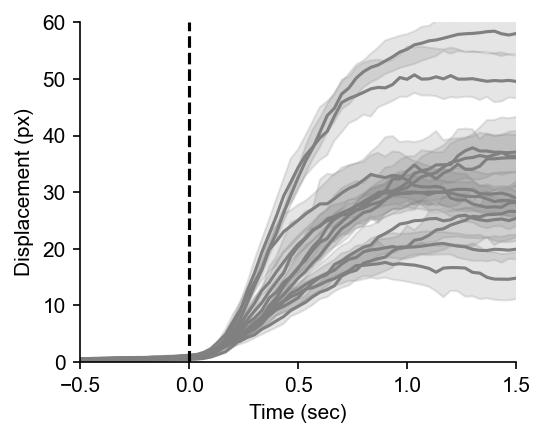

In [5]:
df_pose_orig = df_pose.copy()
df_pose = df_pose_orig.loc[df_pose['Contra']=='contra', :]

# Set custom color palette
sns.set_palette(sns.color_palette(["gray"]))

fig,ax = plt.subplots(1,1,figsize=(3.75,3),dpi=150)
uni_sbj = np.unique(np.asarray(sbj_lst))

for j in tqdm(range(n_subjs)):
    sns.lineplot(x="Time",y="Displ",data=df_pose[df_pose['Sbj']==uni_sbj[j]],ax=ax,
                 linewidth=1.5,hue='Contra',legend=False,
                 estimator=np.median, ci=95)

ax.set_ylim([0,60])
ax.set_xlim([-0.5,1.5])
ax.set_xticks([-0.5,0,0.5,1,1.5])
# plt.setp(ax.get_yticklabels(), fontsize=8, fontweight="normal") #,fontname='Times New Roman'
# plt.setp(ax.get_xticklabels(), fontsize=8, fontweight="normal")
ax.set_ylabel('Displacement (px)') #,fontsize=9,fontweight='normal') #Displacement (px)
ax.set_xlabel('Time (sec)') #,fontsize=9,fontweight='normal') #Time (sec)
sns.set_style("ticks")
sns.despine()
plt.axvline(0, linewidth=1.5, color="black", linestyle="--")
plt.show()

In [ ]:
# fig_sp = '/data1/users/stepeter/mvmt_init/figs/'
# fig_name = 'wrist_displ_v2'
# dpi_plt = 300
# fig.savefig(fig_sp+fig_name+'.png',
#             format='png',transparent= True,dpi=dpi_plt,
#             bbox_inches = 'tight', pad_inches = 0.01,
#             )